# WeRateDogs推特的狗狗的数据清洗和分析

## 项目简介

WeRateDogs 是一个推特主，他以诙谐幽默的方式对人们的宠物狗评分。这些评分通常以 10 作为分母。但是分子则一般大于 10：11/10、12/10、13/10 等等。为什么会有这样的评分？因为 "They're good dogs Brent." WeRateDogs 拥有四百多万关注者，曾受到国际媒体的报道。本项目的目的是对包含了截止到 2017 年 4 月 1 日的 5000 多条推特数(推特 ID、时间戳、推特文本等)进行数据清洗，并创建分析和可视化。

## 背景
你的目标：清洗 WeRateDogs 推特数据，创建有趣且可靠的分析和可视化。这份推特档案很棒，但是只包含基本的推特信息。要达到 "Wow!" 的效果，在分析和可视化前，还需要收集额外的数据、然后进行评估和清洗。

## 数据

### 完善推特档案

WeRateDogs 的推特档案包括 5000 多条推特的基本信息，但并不包括所有内容。不过档案中有一列包含每个推特的文本，我用这一列数据提取了评分、狗的名字和“地位”（即 doggo、floofer、pupper 和 puppo）——这使数据得以“完善”。在这 5000 多条中，我只筛选出了 2356 条包含评分的推特数据。

### 通过推特 API 获取附加数据

回到基础的推特档案：转发数（retweet count）和喜爱数（favorite count）是两个遗漏的列。幸运的是，从推特 API 中，任何人都可以收集到这些数据。其实，"任何人" 只是能获取最多 3000 条的最近推特数据。但是因为你拥有 WeRateDogs 推特档案和其中的推特 ID，你可以收集到这其中所有的 5000 多条推特。你将查询推特 API 来收集这些有价值的数据。

特别提示： 如果你无法访问 Twitter 的话，我们将直接给你提供返回的 Twitter 数据。你可以 右键点击这里选择另存为 下载。该文件为 txt 格式，每一行为一条独立的 twitter 信息，格式为 JSON。该文件比较大，下载可能需要几分钟。

### 图像预测文件

还有一件更酷的事情：我通过一个可以对狗狗种类进行分类的神经网络，运行这份推特档案中的所有图像。获取的结果：一份图像预测结果表格，其中包含了预测结果的前三名，推特 ID，图像 url 以及最可信的预测结果对应的图像编号（由于推特最多包含 4 个图片，所以编号为 1 到 4）。
以该表格中的最后一行数据来理解各列数据：

tweet_id 是推特链接的最后一部分，位于 "status/" 后面 → https://twitter.com/dog_rates/status/889531135344209921
jpg_url 是预测的图像资源链接
img_num 最可信的预测结果对应的图像编号 → 1 推特中的第一张图片
p1 是算法对推特中图片的一号预测 → 金毛犬
p1_conf 是算法的一号预测的可信度 → 95%
p1_dog 是一号预测该图片是否属于“狗”（有可能是其他物种，比如熊、马等） → True 真
p2 是算法对推特中图片预测的第二种可能性 → 拉布拉多犬
p2_conf 是算法的二号预测的可信度 → 1%
p2_dog 是二号预测该图片是否属于“狗” → True 真
以此类推...
从推特中可以看到，对该图像的一号预测（p1）是准确的：
所以这既有趣，也很不错。但是所有附加数据都需要收集、评估和清洗。所以才需要你。

## 关键要点
清洗这个项目的数据时要牢记几个要点：

- 我们只需要含有图片的原始评级 (不包括转发)。尽管数据集中有 5000 多条数据，但是并不是所有都是狗狗评分，并且其中有一些是转发。
- 完整地评估和清理整个数据集将需要大量时间，实践和展示数据处理技巧没有必要将这个数据集全部清理。因此，本项目的要求只是评估和清理此数据集中的至少 8 个质量问题和至少 2 个整洁度问题。
- 根据 整洁数据 tidy data 的规则要求，本项目的数据清理应该包括将三个数据片段进行合并。
- 如果分子评级超过分母评级，不需要进行清洗。这个 特殊评分系统 是 WeRateDogs 人气度较高的主要原因。（同样，也不需要删除分子小于分母的数据）
- 不必收集 2017 年 8 月 1 日之后的数据，你可以收集到这些推特的基本信息，但是你不能收集到这些推特对应的图像预测数据，因为你没有图像预测算法的使用权限。

## 提出问题

- 研究狗狗的评分分布
- 研究不同地位的狗狗的数量分布和关系
- 不同地位的狗狗的数量分布

## 数据整理

### 收集数据

In [1]:
import json
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
plt.rcParams['font.family'] = 'serif'
%matplotlib inline

数据集一:读取包含评分、地位、名字等主要推特信息的档案信息

In [2]:
df_twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')

数据集二:下载并读取包含推特图像预测信息的文件

In [3]:
url = 'https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv'
'''
response = requests.get(url)
with open(url.split('/')[-1], 'w') as f:
    f.write(response.text)
'''
df_image_predictions = pd.read_csv(url.split('/')[-1], '\t', encoding="utf8")

数据集三:获取每条推特的额外附加数据

In [59]:
list_tweet = []
with open("tweet_json.txt", "r") as f_tweet:
    for line in f_tweet:
        dict_tweet = json.loads(line)
        tmp = {
            "retweet_count"  : dict_tweet["retweet_count"],
            "favorite_count" : dict_tweet["favorite_count"],
            "tweet_id"       : str(dict_tweet["id_str"])
        }
        list_tweet.append(tmp)
df_tweet_others = pd.DataFrame(list_tweet)

### 评估

#### 目测评估
df_twitter_archive_enhanced表格进行目测评估
- source代表了用户使用什么样的工具来进行访问，其格式不正确，如<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>需要重新进行数据提取
- 存在转发数据需要进行数据删除，如tweet_id为888202515573088257。
- 存在不含图片的数据需要进行删除，如tweet_id为881633300179243008。
- doggo, floofer, pupper和puppo四列代表狗狗的地位应该合并为stage列
- rating_numerator、rating_denominator两列数据代表狗狗的评分，合并为一列rating，并删除这两列数据

In [11]:
df_twitter_archive_enhanced

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


对df_image_predictions表格进行目测评估
- 预测结果只保留最可能的预测值，将p1, p1_conf,p1_dog,p2, p2_conf,p2_dog,p3, p3_conf,p3_dog合并为p，p_conf, p_dog三列数据

In [6]:
df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [11]:
df_tweet_others

,favorite_count,retweet_count,tweet_id
0,39492,8842,892420643555336193
1,33786,6480,892177421306343426
2,25445,4301,891815181378084864
3,42863,8925,891689557279858688
4,41016,9721,891327558926688256
5,20548,3240,891087950875897856
6,12053,2142,890971913173991426
7,66596,19548,890729181411237888
8,28187,4403,890609185150312448
9,32467,7684,890240255349198849


<div>
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

#### 编程评估

##### `df_twitter_archive_enhanced`表格

查看数据的基本信息
- tweet_id的数据类型应该更改为str
- timestamp的数据类型应该更改为time
- rating_numerator、rating_denominator应该更改以float
- in_reply_to_status_id、in_reply_to_user_id的数据类型应该更改为str
- retweeted_status_id、retweeted_status_user_id的数据类型应该更改为str
- retweeted_status_timestamp的数据类型应该更改为time

In [12]:
df_twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [6]:
df_twitter_archive_enhanced.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


rating_numerator，rating_denominator的类型应该更改为float且需要重新进行提取,例如tweet_id为883482846933004288的rating_numerator应该为13.5

In [14]:
item = df_twitter_archive_enhanced[df_twitter_archive_enhanced["tweet_id"] == 883482846933004288]
print(item["text"].values)
print(item["rating_numerator"].values)
print(item["rating_denominator"].values)

['This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948']
[5]
[10]


In [41]:
item = df_twitter_archive_enhanced.loc[df_twitter_archive_enhanced["rating_numerator"] == 1776, ]
print(item["tweet_id"].values)
print(item["text"].values)
print(item["rating_numerator"].values)
print(item["rating_denominator"].values)

[749981277374128128]
["This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh"]
[1776]
[10]


In [47]:
df_twitter_archive_enhanced.loc[df_twitter_archive_enhanced["rating_numerator"] == 0, ]["text"].values

array(["When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag",
       "PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX"],
      dtype=object)

tweet_id为835246439529840640的rating_numerator应该更改为13, rating_denominator更改为10

In [51]:
item = df_twitter_archive_enhanced.loc[df_twitter_archive_enhanced["rating_denominator"] == 0, ]
print(item["tweet_id"])
print(item["text"].values)
print(item["rating_numerator"].values)
print(item["rating_denominator"].values)

313    835246439529840640
Name: tweet_id, dtype: int64
["@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"]
[960]
[0]


In [53]:
item = df_twitter_archive_enhanced.loc[df_twitter_archive_enhanced["rating_denominator"] == 170, ]
print(item["tweet_id"])
print(item["text"].values)
print(item["rating_numerator"].values)
print(item["rating_denominator"].values)

1120    731156023742988288
Name: tweet_id, dtype: int64
['Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv']
[204]
[170]


检查tweet_id是否存在重复值,无重复值

In [5]:
df_twitter_archive_enhanced["tweet_id"].duplicated().sum()

0

查看name的唯一值情况

In [64]:
df_twitter_archive_enhanced["name"].unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Lilly', 'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella',
       'Grizzwald', 'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey',
       'Gary', 'a', 'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey',
       'Duddles', 'Jack', 'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow',
       'Terrance', 'Aja', 'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict',
       'Venti', 'Goose', 'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian',
       'Walter', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Dawn', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'quite', 'Dewey', 'Scout', 'Gizmo', 'Cooper', 'Harold', 'Shikha',
       'Jamesy', 'Lili', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Nept

- 存在非狗类的数据，需要进行删除，筛选text中包含We only rate dogs, Dogs are what we rate, It is not a dog的数据

In [67]:
df_twitter_archive_enhanced[df_twitter_archive_enhanced["name"] == "a"]["text"].values

array(['Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF',
       'Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq',
       'Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn',
       'This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW',
       'Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R',
       'This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2',
       'This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10

In [68]:
df_twitter_archive_enhanced[df_twitter_archive_enhanced["name"] == "an"]["text"].values

array(['RT @dog_rates: This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR',
       "This is an Iraqi Speed Kangaroo. It is not a dog. Please only send in dogs. I'm very angry with all of you ...9/10 https://t.co/5qpBTTpgUt",
       'This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR',
       'This is an Irish Rigatoni terrier named Berta. Completely made of rope. No eyes. Quite large. Loves to dance. 10/10 https://t.co/EM5fDykrJg',
       'This is an extremely rare horned Parthenon. Not amused. Wears shoes. Overall very nice. 9/10 would pet aggressively https://t.co/QpRjllzWAL',
       'This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv',
       "This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well.

存在name为a, an, None提取错误，如tweet_id为667524857454854144，提取H(h)is name is, named,否则name更改为np.nan。

In [69]:
df_twitter_archive_enhanced[df_twitter_archive_enhanced["name"] == "None"]["text"].values

array(["Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh",
       "When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq",
       "Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm",
       'You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV',
       'This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp',
       '@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution',
       'RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo',
       'I have a new hero and his name is Howard. 14/10 https://t.co/

In [15]:
df_twitter_archive_enhanced.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

`df_twitter_archive_enhanced`各列代表的意义:
- tweet_id: twitter ID
- in_reply_to_status_id:
- in_reply_to_user_id
- timestamp:时间戳
- source:用户访问的设备
- text:推特原文
- retweeted_status_id
- retweeted_status_user_id:
- retweeted_status_timestamp:
- expanded_urls:
- rating_numerator:评分的分母
- rating_denominator:评分的分子
- name:狗的名字
- doggo: 狗的地位
- floofer:狗的地位
- pupper: 狗的地位
- puppo: 狗的地位

##### `df_image_predictions`表格
- tweet_id的数据类型更改为str.

In [16]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [17]:
df_image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


检查tweet_id无重复值

In [57]:
df_image_predictions["tweet_id"].duplicated().sum()

0

In [62]:
df_image_predictions.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

df_image_predictions各列数据代表的意义:
- tweet_id:推特链接的最后一部分，位于 "status/" 后面 → https://twitter.com/dog_rates/status/889531135344209921
- jpg_url 是预测的图像资源链接
- img_num 最可信的预测结果对应的图像编号 → 1 推特中的第一张图片
- p1 是算法对推特中图片的一号预测 → 金毛犬
- p1_conf 是算法的一号预测的可信度 → 95%
- p1_dog 是一号预测该图片是否属于“狗”（有可能是其他物种，比如熊、马等） → True 真
- p2 是算法对推特中图片预测的第二种可能性 → 拉布拉多犬
- p2_conf 是算法的二号预测的可信度 → 1%
- p2_dog 是二号预测该图片是否属于“狗” → True 真
- p3 是算法对推特中图片预测的第三种可能性 → 拉布拉多犬
- p3_conf 是算法的三号预测的可信度 → 1%
- p3_dog 是三号预测该图片是否属于“狗” → True 真

##### `df_tweet_others`表格

In [60]:
df_tweet_others.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 3 columns):
favorite_count    2352 non-null int64
retweet_count     2352 non-null int64
tweet_id          2352 non-null object
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


In [61]:
df_tweet_others.describe()

,favorite_count,retweet_count
count,2352.000000,2352.000000
mean,8109.198980,3134.932398
std,11980.795669,5237.846296
min,0.000000,0.000000
25%,1417.000000,618.000000
50%,3596.500000,1456.500000
75%,10118.000000,3628.750000
max,132318.000000,79116.000000


In [20]:
df_tweet_others.columns

Index(['favorite_count', 'retweet_count', 'tweet_id'], dtype='object')

`df_tweet_others`表格各列数据代表的意义:
- retweet_count:转发数
- favorite_count:喜爱数
- tweet_id:twitter ID

##### 质量
###### `df_twitter_archive_enhanced`表格
- source代表了用户使用什么样的工具来进行访问，其格式不正确，如<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>需要重新进行数据提取
- 存在转发数据需要进行数据删除，如tweet_id为888202515573088257。
    - 删除retweeted_status_id不为空的数据
    - text中含RT @的数据
- 存在不含图片的数据需要进行删除，如tweet_id为881633300179243008。
    - df_tweet_others的jpg_url代表图片资源，将这两个表格进行内连接
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp对狗狗的评分无意义删除相关列数据。
- tweet_id、timestamp、retweeted_status_id、retweeted_status_user_id、retweeted_status_timestamp的数据类型错误，分别更改为str、datetime、str、str、datetime
- rating_numerator、rating_denominator数据不准确，需要重新进行提取,例如tweet_id为883482846933004288的rating_numerator应该为13.5,且数据类型需要更改为float。
- tweet_id为835246439529840640的rating_numerator应该更改为13, rating_denominator更改为10
- 存在非狗类的数据，需要进行删除，筛选text中包含We only rate dogs, Dogs are what we rate, It is not a dog的数据
- 存在name为a, an, None提取错误，如tweet_id为667524857454854144，提取H(h)is name is, named,否则name更改为np.nan。
- 存在转发数和喜爱数位于df_tweet_others表格中，数据不完整，需要将df_image_predictions、df_tweet_others、df_twitter_archive_enhanced三个表格合并为一个表格。
###### `df_image_predictions` 表格
- tweet_id的数据类型更改为str.

##### 整洁度
###### `df_twitter_archive_enhanced`表格
- doggo, floofer, pupper和puppo四列代表狗狗的地位应该合并为stage列并删除这四列数据。
- rating_numerator、rating_denominator两列数据代表狗狗的评分，合并为一列rating，并删除这两列数据

###### `df_tweet_others` 表格
- 预测结果只保留最可能的预测值，将p1, p1_conf,p1_dog,p2, p2_conf,p2_dog,p3, p3_conf,p3_dog合并为p，p_conf, p_dog三列数据
### 清理

清洗前，进行数据备份

In [216]:
df_cleaned_twitter_archive_enhanced = df_twitter_archive_enhanced.copy()
df_cleaned_image_predictions = df_image_predictions.copy()
df_cleaned_tweet_others = df_tweet_others.copy()

#### 问题定义1：更改数据类型错误问题
- df_twitter_archive_enhanced表格中tweet_id、timestamp、retweeted_status_id、retweeted_status_user_id、retweeted_status_timestamp的数据类型错误，分别更改为str、datetime、str、str、datetime
- df_image_predictions表格中tweet_id的数据类型更改为str.

#### 代码

In [229]:
df_cleaned_twitter_archive_enhanced["tweet_id"] = df_cleaned_twitter_archive_enhanced["tweet_id"].astype(str)
df_cleaned_twitter_archive_enhanced["timestamp"] = pd.to_datetime(df_cleaned_twitter_archive_enhanced["timestamp"])
#更改为str之后nan数值丢失，待确认修改方式
#df_cleaned_twitter_archive_enhanced["retweeted_status_id"] = df_cleaned_twitter_archive_enhanced["retweeted_status_id"].astype(str)
df_cleaned_twitter_archive_enhanced["retweeted_status_timestamp"] = \
               pd.to_datetime(df_cleaned_twitter_archive_enhanced["retweeted_status_timestamp"])
df_cleaned_image_predictions["tweet_id"] = df_cleaned_image_predictions["tweet_id"].astype(str)

KeyError: 'retweeted_status_timestamp'

#### 测试

In [205]:
df_cleaned_twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [203]:
df_cleaned_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


#### 问题定义2 : 存在转发数据需要进行数据删除，如tweet_id为888202515573088257。
- 删除retweeted_status_id不为空的数据
- text中含RT @的数据

#### 代码

In [217]:
indies_retweeted_not_na = df_cleaned_twitter_archive_enhanced[df_cleaned_twitter_archive_enhanced["retweeted_status_id"].notna()].index.tolist()
df_cleaned_twitter_archive_enhanced.drop(indies_retweeted_not_na, axis=0, inplace=True)

indexs_rt = df_cleaned_twitter_archive_enhanced[df_cleaned_twitter_archive_enhanced["text"].str.contains("RT@")].index.tolist()
df_cleaned_twitter_archive_enhanced.drop(indexs_rt, axis=0, inplace=True)

#### 测试

In [148]:
df_cleaned_twitter_archive_enhanced["retweeted_status_id"].notna().sum()

0

In [149]:
df_cleaned_twitter_archive_enhanced["text"].str.contains("RT @").sum()

0

#### 问题定义3：- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp对狗狗的评分无意义删除相关列数据。

##### 代码

In [218]:
df_cleaned_twitter_archive_enhanced.drop(["in_reply_to_status_id", "in_reply_to_user_id",
            "retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp"], inplace = True, axis = 1)

##### 测试

In [208]:
df_cleaned_twitter_archive_enhanced.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

#### 问题定义4： 存在不含图片的数据需要进行删除，如tweet_id为881633300179243008。
- df_tweet_others的jpg_url代表图片资源，将这两个表格进行内连接

#### 代码

In [128]:
df_cleaned_twitter_archive_enhanced = pd.concat([df_cleaned_twitter_archive_enhanced, df_cleaned_tweet_others],
                                                join="inner", axis = 1)

#### 问题定义5: rating_numerator、rating_denominator数据不准确，需要重新进行提取,例如tweet_id为883482846933004288的rating_numerator应该为13.5,且数据类型需要更改为float。

#### 问题定义5:doggo, floofer, pupper和puppo四列代表狗狗的地位应该合并为stage列并删除这四列数据。
- tweets记录包含不止一个stage值的情况，保留每一个出现的stage值，同时不同的值之间用符号隔开

#### 代码

In [225]:
# 提取包含地位相关的字段
df_cleaned_twitter_archive_enhanced["stage"] = df_cleaned_twitter_archive_enhanced["text"].str.lower()\
        .str.findall(r'(doggo|floof|pupper|puppo)')
# 去重
df_cleaned_twitter_archive_enhanced["stage"] = df_cleaned_twitter_archive_enhanced["stage"].apply(lambda x:set(x))
df_cleaned_twitter_archive_enhanced["stage"] = df_cleaned_twitter_archive_enhanced["stage"].apply(lambda x:";".join(x))
df_cleaned_twitter_archive_enhanced["stage"] = df_cleaned_twitter_archive_enhanced["stage"].replace("", np.nan)
df_cleaned_twitter_archive_enhanced.drop(["doggo", "floofer", "pupper", "puppo"], axis=1, inplace=True)

#### 测试

In [223]:
df_cleaned_twitter_archive_enhanced["stage"].unique()

array([nan, 'doggo', 'puppo', 'floof', 'pupper', 'doggo;puppo',
       'doggo;floof', 'pupper;doggo', 'doggo;pupper', 'pupper;floof'],
      dtype=object)

In [226]:
df_cleaned_twitter_archive_enhanced.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'stage'],
      dtype='object')

In [ ]:
#### 

##### `df_twitter_archive_enhanced`表格source代表了用户使用什么样的工具来进行访问，其格式不正确，重新进行数据提取

In [90]:
df_cleaned_twitter_archive_enhanced["source"] = df_cleaned_twitter_archive_enhanced["source"].str.extract(r">(.*)</a>", expand=True)

##### 测试

In [91]:
df_cleaned_twitter_archive_enhanced["source"].unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene',
       'TweetDeck'], dtype=object)

#### 清洁度

##### doggo, floofer, pupper和puppo四列代表狗狗的地位应该合并为stage列

##### 代码

In [75]:
def handleStage(doggo, floofer, pupper, puppo):
    if doggo.lower() != "none":
        return doggo
    else:
        if floofer.lower() != "none":
            return floofer
        else:
            if pupper.lower() != "none":
                return pupper
            else:
                if puppo.lower() != "none":
                    return puppo
                else:
                    return np.nan
df_cleaned_twitter_archive_enhanced.loc[:, "stage"] = df_cleaned_twitter_archive_enhanced.apply(lambda df : handleStage(df.doggo, df.floofer, df.pupper, df.puppo), axis = 1)

In [76]:
df_cleaned_twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2356 non-null int64
text                  2356 non-null object
expanded_urls         2356 non-null object
rating_numerator      2356 non-null float64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
stage                 380 non-null object
rating                2356 non-null float64
dtypes: float64(2), int64(2), object(8)
memory usage: 221.0+ KB


##### 测试

In [77]:
flag = ((df_cleaned_twitter_archive_enhanced["doggo"].str.lower() != "none") | \
        (df_cleaned_twitter_archive_enhanced["floofer"].str.lower() != "none") | \
        (df_cleaned_twitter_archive_enhanced["pupper"].str.lower() != "none") | \
        (df_cleaned_twitter_archive_enhanced["puppo"].str.lower() != "none"))
df_cleaned_twitter_archive_enhanced[flag][["doggo", "floofer", "pupper", "puppo", "stage"]]

,doggo,floofer,pupper,puppo,stage
9,doggo,None,None,None,doggo
12,None,None,None,puppo,puppo
14,None,None,None,puppo,puppo
29,None,None,pupper,None,pupper
43,doggo,None,None,None,doggo
46,None,floofer,None,None,floofer
49,None,None,pupper,None,pupper
56,None,None,pupper,None,pupper
71,None,None,None,puppo,puppo
78,None,None,pupper,None,pupper


##### rating_numerator、rating_denominator两列数据代表狗狗的评分

##### 代码


In [78]:
df_cleaned_twitter_archive_enhanced.loc[:, "rating"] =  df_cleaned_twitter_archive_enhanced["rating_numerator"] /df_cleaned_twitter_archive_enhanced["rating_denominator"]

##### 测试

In [79]:
df_cleaned_twitter_archive_enhanced.head()[["rating_numerator", "rating_denominator", "rating"]]

,rating_numerator,rating_denominator,rating
0,13.0,10,1.3
1,13.0,10,1.3
2,12.0,10,1.2
3,13.0,10,1.3
4,12.0,10,1.2


#### 将df_tweet_others的retweet_count、favorite_count复制到df_twitter_archive_enhanced

##### 代码

In [28]:
df_cleaned_twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2356 non-null int64
text                  2356 non-null object
expanded_urls         2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
stage                 380 non-null object
rating                2356 non-null float64
dtypes: float64(1), int64(3), object(8)
memory usage: 221.0+ KB


In [81]:
df_cleaned_twitter_archive_enhanced = pd.merge(df_cleaned_twitter_archive_enhanced, df_cleaned_tweet_others, how="left", on = "tweet_id")

##### 测试

In [82]:
df_cleaned_twitter_archive_enhanced.head()

,tweet_id,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage,rating,favorite_count,retweet_count
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,None,None,None,None,NaN,1.3,39492.0,8842.0
1,892177421306343426,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None,None,None,None,NaN,1.3,33786.0,6480.0
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,None,None,None,None,NaN,1.2,25445.0,4301.0
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,None,None,None,None,NaN,1.3,42863.0,8925.0
4,891327558926688256,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,None,None,None,None,NaN,1.2,41016.0,9721.0


#### 质量问题

##### 问题 ：name为None的提取错误
- 2269 Tickles
- 2267 Big Jumpy Rat
- 2237 Oliver
- 2227 Guss
- 2166 Zeus
- 1991 Kony
- 1852 Reggie
- 1842 Yoshi
- 1811 Airbud
- 1784 Yoda
- 1782 Cindy
- 1734 Sabertooth
- 1729 hooman
- 1684 Toby
- 1630 Pippa
- 1609 Jack
- 1248 puparazzi
- 843 Charley
- 774 Atlas
- 754 Narcos
- 684 Atlas
- 657 Vine
- 624 Elder
- 603 Tickles
- 600 squishy
- 555 Jesus
- 539 Hooman
- 508 Augie
- 513 Augie
- 30, name更改为tanner
- 35，name更改为Howard
- 72,name更改为Martha
- 101 Penelope
- 149 Pablo
- 177 Meeko
- 186 Kardashians
- 199 scarf
- 228 Jerry
- 234 Cannon
- 251 Toby
- 275 Kevin
- 306 Atlas
- 313 jomny
- 391 Dew
- 508 Jake

##### 代码

In [30]:
tmp = df_cleaned_twitter_archive_enhanced[df_cleaned_twitter_archive_enhanced["name"].str.lower() == "none"]
for index, row in df_cleaned_twitter_archive_enhanced.iterrows():
    if row["name"].lower() == "none":
        print(index, row["name"], row["rating_numerator"], row["rating_denominator"], row["stage"], row["text"])

5 None 13 10 nan Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh
7 None 13 10 nan When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq
12 None 13 10 puppo Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm
24 None 13 10 nan You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV
25 None 12 10 nan This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp
30 None 12 10 nan @NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution
32 None 12 10 nan RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo
35 None 14 10

742 None 12 10 nan RT @Patreon: Well. @dog_rates is on Patreon. 

12/10. 

https://t.co/rnKvzt6RJs https://t.co/v4e2ywe8iO
744 None 11 10 nan We only rate dogs. Pls stop sending in non-canines like this Urban Floof Giraffe. I can't handle this. 11/10 https://t.co/zHIqpM5Gni
746 None 10 10 doggo Here's a doggo questioning his entire existence. 10/10 someone tell him he's a good boy  https://t.co/dVm5Hgdpeb
748 None 12 10 pupper Have you ever seen such a smol pupper? Portable af. 12/10 would keep in shirt pocket https://t.co/KsqaIzlQ12
751 None 13 10 nan Everybody drop what you're doing and look at this dog. 13/10 must be super h*ckin rare https://t.co/I1bJUzUEW5
753 None 13 10 nan RT @dog_rates: In case you haven't seen the most dramatic sneeze ever... 13/10 https://t.co/iy7ylyZcsE
754 None 13 10 nan Oh my god it's Narcos but Barkos. 13/10 someone please make this happen
https://t.co/tird9cIlzB
758 None 14 10 nan RIP Loki. Thank you for the good times. You will be missed by many. 14/10 

1552 None 11 10 pupper This pupper just wants to say hello. 11/10 would knock down fence for https://t.co/A8X8fwS78x
1554 None 10 10 nan When you have a ton of work to do but then remember you have tomorrow off. 10/10 https://t.co/MfEaMUFYTx
1557 None 12 10 nan When you stumble but recover quickly cause your crush is watching. 12/10 https://t.co/PMeq6IedU7
1560 None 12 10 pupper This pupper is sprouting a flower out of her head. 12/10 revolutionary af https://t.co/glmvQBRjv4
1564 None 10 10 nan Please send dogs. I'm tired of seeing other stuff like this dangerous pirate. We only rate dogs. Thank you... 10/10 https://t.co/YdLytdZOqv
1566 None 13 10 nan 13/10 I can't stop watching this (vid by @k8lynwright) https://t.co/nZhhMRr5Hp
1568 None 12 10 pupper With great pupper comes great responsibility. 12/10 https://t.co/hK6xB042EP
1574 None 12 10 nan Another magnificent photo. 12/10 https://t.co/X5w387K5jr
1579 None 7 10 pupper "You got any games on your phone" 7/10 for invasive brown Dalma

2322 None 6 10 nan Oh boy what a pup! Sunglasses take this one to the next level. Weirdly folds front legs. Pretty big. 6/10 https://t.co/yECbFrSArM
2323 None 7 10 nan Here we have an Austrian Pulitzer. Collectors edition. Levitates (?). 7/10 would garden with https://t.co/NMQq6HIglK
2324 None 12 10 nan *internally screaming* 12/10 https://t.co/YMcrXC2Y6R
2328 None 9 10 nan Oh goodness. A super rare northeast Qdoba kangaroo mix. Massive feet. No pouch (disappointing). Seems alert. 9/10 https://t.co/Dc7b0E8qFE
2329 None 11 10 nan Those are sunglasses and a jean jacket. 11/10 dog cool af https://t.co/uHXrPkUEyl
2330 None 6 10 nan Unique dog here. Very small. Lives in container of Frosted Flakes (?). Short legs. Must be rare 6/10 would still pet https://t.co/XMD9CwjEnM
2331 None 8 10 nan Here we have a mixed Asiago from the Galápagos Islands. Only one ear working. Big fan of marijuana carpet. 8/10 https://t.co/tltQ5w9aUO
2332 None 10 10 nan Look at this jokester thinking seat belt laws do

In [83]:
df_cleaned_twitter_archive_enhanced.loc[2269, "name"] = "Tickles"
df_cleaned_twitter_archive_enhanced.loc[2267, "name"] = "Big Jumpy Rat"
df_cleaned_twitter_archive_enhanced.loc[2227, "name"] = "Guss"
df_cleaned_twitter_archive_enhanced.loc[2166, "name"] = "Zeus"
df_cleaned_twitter_archive_enhanced.loc[1991, "name"] = "Kony"
df_cleaned_twitter_archive_enhanced.loc[1852, "name"] = "Reggie"
df_cleaned_twitter_archive_enhanced.loc[1842, "name"] = "Yoshi"
df_cleaned_twitter_archive_enhanced.loc[1811, "name"] = "Airbud"
df_cleaned_twitter_archive_enhanced.loc[1784, "name"] = "Yoda"
df_cleaned_twitter_archive_enhanced.loc[1782, "name"] = "Cindy"
df_cleaned_twitter_archive_enhanced.loc[1734, "name"] = "Sabertooth"
df_cleaned_twitter_archive_enhanced.loc[1729, "name"] = "hooman"
df_cleaned_twitter_archive_enhanced.loc[1684, "name"] = "Toby"
df_cleaned_twitter_archive_enhanced.loc[1630, "name"] = "Pippa"
df_cleaned_twitter_archive_enhanced.loc[1609, "name"] = "Jack"
df_cleaned_twitter_archive_enhanced.loc[1248, "name"] = "puparazzi"
df_cleaned_twitter_archive_enhanced.loc[843, "name"] = "Charley"
df_cleaned_twitter_archive_enhanced.loc[774, "name"] = "Atlas"
df_cleaned_twitter_archive_enhanced.loc[754, "name"] = "Narcos"
df_cleaned_twitter_archive_enhanced.loc[684, "name"] = "Atlas"
df_cleaned_twitter_archive_enhanced.loc[657, "name"] = "Vine"
df_cleaned_twitter_archive_enhanced.loc[624, "name"] = "Elder"
df_cleaned_twitter_archive_enhanced.loc[603, "name"] = "Tickles"
df_cleaned_twitter_archive_enhanced.loc[600, "name"] = "squishy"
df_cleaned_twitter_archive_enhanced.loc[555, "name"] = "Jesus"
df_cleaned_twitter_archive_enhanced.loc[539, "name"] = "Hooman"
df_cleaned_twitter_archive_enhanced.loc[508, "name"] = "Augie"
df_cleaned_twitter_archive_enhanced.loc[513, "name"] = "Augie"
df_cleaned_twitter_archive_enhanced.loc[30, "name"] = "tanner"
df_cleaned_twitter_archive_enhanced.loc[35, "name"] = "Howard"
df_cleaned_twitter_archive_enhanced.loc[72, "name"] = "Martha"
df_cleaned_twitter_archive_enhanced.loc[101, "name"] = "Penelope"
df_cleaned_twitter_archive_enhanced.loc[149, "name"] = "Pablo"
df_cleaned_twitter_archive_enhanced.loc[177, "name"] = "Meeko"
df_cleaned_twitter_archive_enhanced.loc[186, "name"] = "Kardashians"
df_cleaned_twitter_archive_enhanced.loc[199, "name"] = "scarf"
df_cleaned_twitter_archive_enhanced.loc[228, "name"] = "Jerry"
df_cleaned_twitter_archive_enhanced.loc[234, "name"] = "Cannon"
df_cleaned_twitter_archive_enhanced.loc[251, "name"] = "Toby"
df_cleaned_twitter_archive_enhanced.loc[275, "name"] = "Kevin"
df_cleaned_twitter_archive_enhanced.loc[306, "name"] = "Atlas"
df_cleaned_twitter_archive_enhanced.loc[391, "name"] = "Dew"
df_cleaned_twitter_archive_enhanced.loc[508, "name"] = "Jake"
df_cleaned_twitter_archive_enhanced.loc[313, "name"] = "jomny"

##### 测试

In [84]:
df_cleaned_twitter_archive_enhanced.iloc[2269]["name"]

'Tickles'

##### 问题：name为such的提取错误

##### 代码

In [85]:
tmp = df_cleaned_twitter_archive_enhanced[df_cleaned_twitter_archive_enhanced["name"].str.lower() == "such"]
for index, row in tmp.iterrows():
    if row["name"].lower() == "such":
        print(index, row["name"], row["rating_numerator"], row["rating_denominator"], row["stage"], row["text"])

- 22行，name为such，更改为Wiener

In [86]:
df_cleaned_twitter_archive_enhanced.loc[22, "name"] = "Wiener"

##### 测试

In [35]:
df_cleaned_twitter_archive_enhanced.loc[22, "name"]

'Wiener'

##### 问题：name为quite的信息提取错误
- 2326行name更改为None

##### 代码

In [87]:
tmp = df_cleaned_twitter_archive_enhanced[df_cleaned_twitter_archive_enhanced["name"].str.lower() == "quite"]
for index, row in tmp.iterrows():
    if row["name"].lower() == "quite":
        print(index, row["name"], row["rating_numerator"], row["rating_denominator"], row["stage"], row["text"])

118 quite 12.0 10 nan RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…
169 quite 12.0 10 nan We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9
193 quite 12.0 10 nan Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x


In [37]:
df_cleaned_twitter_archive_enhanced.loc[2326, "name"] = "None"

##### 测试

In [88]:
df_cleaned_twitter_archive_enhanced.loc[2326, "name"] 

'None'

##### 问题：name为a的提取错误
- 56, 649,1002，1049，1340，1351，1368，1382，1499，1785,1878,1923,1941，2222, 2327,2334,2347, 2348, 2350, 2352, 2353, 2354行name更改为None
- 1853更改为Wylie
- 1994更改为Rand Paul
- 2034 Jacob
- 2066 Rufus
- 2116 Spork
- 2125 Cherokee
- 2128 Hemry
- 2235 Alfonso
- 2249 Cheryl
- 2255Jessiga
- 2264 Klint
- 2273 Kohl
- 2287 Daryl
- 2304 Pepe
- 2311 Octaviath
- 2314 Johm

##### 代码

In [89]:
tmp = df_cleaned_twitter_archive_enhanced[df_cleaned_twitter_archive_enhanced["name"].str.lower() == "a"]
for index, row in tmp.iterrows():
    if row["name"].lower() == "a":
        print(index, row["name"], row["rating_numerator"], row["rating_denominator"], row["stage"], row["text"])

801 a 10.0 10 nan Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn
1004 a 4.0 10 nan Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R
1017 a 11.0 10 nan This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2
1193 a 11.0 10 nan People please. This is a Deadly Mediterranean Plop T-Rex. We only rate dogs. Only send in dogs. Thanks you... 11/10 https://t.co/2ATDsgHD4n
1207 a 10.0 10 nan This is a taco. We only rate dogs. Please only send in dogs. Dogs are what we rate. Not tacos. Thank you... 10/10 https://t.co/cxl6xGY8B9
1361 a 11.0 10 nan This is a Butternut Cumberfloof. It's not windy they just look like that. 11/10 back at it again with the red socks https://t.co/hMjzhdUHaW
1737 a 7.0 10 nan Guys this really needs to stop. We've

In [90]:
for i in [56, 649, 1002, 1049, 1340, 1351, 1368, 1382, 1499, 1785, 1878, 1923,\
              1941, 2222, 2327,2334,2347, 2348, 2350, 2352, 2353, 2354]:
    df_cleaned_twitter_archive_enhanced.loc[i, "name"] = "None"
df_cleaned_twitter_archive_enhanced.loc[1853, "name"] = "Wylie"
df_cleaned_twitter_archive_enhanced.loc[1994, "name"] = "Rand Paul"
df_cleaned_twitter_archive_enhanced.loc[2034, "name"] = "Jacob"
df_cleaned_twitter_archive_enhanced.loc[2066, "name"] = "Rufus"
df_cleaned_twitter_archive_enhanced.loc[2116, "name"] = "Spork"
df_cleaned_twitter_archive_enhanced.loc[2125, "name"] = "Cherokee"
df_cleaned_twitter_archive_enhanced.loc[2128, "name"] = "Hemry"
df_cleaned_twitter_archive_enhanced.loc[2235, "name"] = "Alfonso"
df_cleaned_twitter_archive_enhanced.loc[2249, "name"] = "Cheryl"
df_cleaned_twitter_archive_enhanced.loc[2255, "name"] = "Jessiga"
df_cleaned_twitter_archive_enhanced.loc[2264, "name"] = "Klint"
df_cleaned_twitter_archive_enhanced.loc[2273, "name"] = "Kohl"
df_cleaned_twitter_archive_enhanced.loc[2287, "name"] = "Daryl"
df_cleaned_twitter_archive_enhanced.loc[2304, "name"] = "Pepe"
df_cleaned_twitter_archive_enhanced.loc[2311, "name"] = "Octaviath"
df_cleaned_twitter_archive_enhanced.loc[2314, "name"] = "Johm"

##### 测试

In [37]:
for i in [56, 649, 1002, 1049, 1340, 1351, 1368, 1382, 1499, 1785, 1878, 1923,\
              1941, 2222, 2327,2334,2347, 2348, 2350, 2352, 2353, 2354]:
    if df_cleaned_twitter_archive_enhanced.loc[i, "name"] != "None":
        print(df_cleaned_twitter_archive_enhanced.loc[i, "name"])

##### 问题：name为an的提取错误
- 2204 Berta
- 2349,2333, 2335None
- 2335 None 9/10
##### 代码

In [41]:
tmp = df_cleaned_twitter_archive_enhanced[df_cleaned_twitter_archive_enhanced["name"].str.lower() == "an"]
for index, row in tmp.iterrows():
    if row["name"].lower() == "an":
        print(index, row["name"], row["rating_numerator"], row["rating_denominator"], row["stage"], row["text"])

759 an 10 10 nan RT @dog_rates: This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR
1025 an 9 10 nan This is an Iraqi Speed Kangaroo. It is not a dog. Please only send in dogs. I'm very angry with all of you ...9/10 https://t.co/5qpBTTpgUt
1362 an 10 10 nan This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR
2204 an 10 10 nan This is an Irish Rigatoni terrier named Berta. Completely made of rope. No eyes. Quite large. Loves to dance. 10/10 https://t.co/EM5fDykrJg
2333 an 9 10 nan This is an extremely rare horned Parthenon. Not amused. Wears shoes. Overall very nice. 9/10 would pet aggressively https://t.co/QpRjllzWAL
2335 an 1 2 nan This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
2349 an 2 10 nan This is an odd dog. Hard on the outside but loving on the

In [91]:
df_cleaned_twitter_archive_enhanced.loc[2204, "name"] = "Berta"
for i in [2349, 2333, 2335]:
    df_cleaned_twitter_archive_enhanced.loc[i, "name"] = "None"
df_cleaned_twitter_archive_enhanced.loc[2335, "rating_numerator"] = 9
df_cleaned_twitter_archive_enhanced.loc[2335, "rating_denominator"] = 10 
df_cleaned_twitter_archive_enhanced.loc[2335, "rating"] = 0.9

##### 测试

In [92]:
print(df_cleaned_twitter_archive_enhanced.loc[2204, "name"])
print(df_cleaned_twitter_archive_enhanced.loc[2335, "rating_numerator"],\
    df_cleaned_twitter_archive_enhanced.loc[2335, "rating_denominator"])

Berta
9.0 10


##### 问题：name为the的提取错误
- 1603, 1797, 1815, 2037,2345,2346 None
- 2212 vine
##### 代码

In [44]:
tmp = df_cleaned_twitter_archive_enhanced[df_cleaned_twitter_archive_enhanced["name"].str.lower() == "the"]
for index, row in tmp.iterrows():
    if row["name"].lower() == "the":
        print(index, row["name"], row["rating_numerator"], row["rating_denominator"], row["stage"], row["text"])

1527 the 9 10 nan Stop sending in lobsters. This is the final warning. We only rate dogs. Thank you... 9/10 https://t.co/B9ZXXKJYNx
1603 the 8 10 pupper This is the newly formed pupper a capella group. They're just starting out but I see tons of potential. 8/10 for all https://t.co/wbAcvFoNtn
1797 the 10 10 pupper This is the happiest pupper I've ever seen. 10/10 would trade lives with https://t.co/ep8ATEJwRb
1815 the 12 10 nan This is the saddest/sweetest/best picture I've been sent. 12/10 😢🐶 https://t.co/vQ2Lw1BLBF
2037 the 13 10 nan This is the best thing I've ever seen so spread it like wildfire &amp; maybe we'll find the genius who created it. 13/10 https://t.co/q6RsuOVYwU
2212 the 13 10 nan Never forget this vine. You will not stop watching for at least 15 minutes. This is the second coveted.. 13/10 https://t.co/roqIxCvEB3
2345 the 10 10 nan This is the happiest dog you will ever see. Very committed owner. Nice couch. 10/10 https://t.co/RhUEAloehK
2346 the 8 10 nan Here is the Ra

In [93]:
for i in [1603, 1797, 1815, 2037,2345,2346]:
    df_cleaned_twitter_archive_enhanced.loc[i, "name"] = "None"
df_cleaned_twitter_archive_enhanced.loc[2212, "name"] = "vine"

##### 测试

In [46]:
for i in [1603, 1797, 1815, 2037,2345,2346]:
    print(df_cleaned_twitter_archive_enhanced.loc[i, "name"])
df_cleaned_twitter_archive_enhanced.loc[2212, "name"]

None
None
None
None
None
None


'vine'

##### 问题：rating_numerator的数据类型为int64，更改为float
##### 代码

##### 问题：rating_numerator、rating_denominator存在错误
- 313 960, 0更改为13， 10
- 1689评分，5， 10，修改为9.5， 10
- 1901 两只狗，评分分别是5/10和8/10，而非5/10,取均值6.5/10
- 2272两条狗，7/10 and 8/10,取均值7.5/10
##### 代码

In [94]:
df_cleaned_twitter_archive_enhanced.loc[313, "rating_numerator"] = 13
df_cleaned_twitter_archive_enhanced.loc[313, "rating_denominator"] = 10
df_cleaned_twitter_archive_enhanced.loc[313, "rating"] = 1.3
df_cleaned_twitter_archive_enhanced.loc[1689, "rating_numerator"] = 9.5
df_cleaned_twitter_archive_enhanced.loc[1689, "rating_denominator"] = 10
df_cleaned_twitter_archive_enhanced.loc[1689, "rating"] = 0.95
df_cleaned_twitter_archive_enhanced.loc[2272, "rating_numerator"] = 7.5
df_cleaned_twitter_archive_enhanced.loc[2272, "rating_denominator"] = 10
df_cleaned_twitter_archive_enhanced.loc[2272, "rating"] = 0.75
df_cleaned_twitter_archive_enhanced.loc[1901, "rating_numerator"] = 6.5
df_cleaned_twitter_archive_enhanced.loc[1901, "rating_denominator"] = 10
df_cleaned_twitter_archive_enhanced.loc[1901, "rating"] = 0.65 

##### 测试

In [48]:
print(df_cleaned_twitter_archive_enhanced.loc[313, "rating_numerator"],
    df_cleaned_twitter_archive_enhanced.loc[313, "rating_denominator"],
    df_cleaned_twitter_archive_enhanced.loc[1689, "rating_numerator"],
    df_cleaned_twitter_archive_enhanced.loc[1689, "rating_denominator"],
    df_cleaned_twitter_archive_enhanced.loc[2272, "rating_numerator"],
    df_cleaned_twitter_archive_enhanced.loc[2272, "rating_denominator"],
    df_cleaned_twitter_archive_enhanced.loc[1901, "rating_numerator"],
    df_cleaned_twitter_archive_enhanced.loc[1901, "rating_denominator"])

13.0 10 9.5 10 7.5 10 6.5 10


##### 问题8：存在非狗类数据
- 5, 25, 47, 59, 62, 93,96,100, 103, 112, 127,131, 141, 154, 200, 202, 212, 213,221, 224, 226, 238, 243, 245, 246,269, 274, 281,290, 291, 314, 375, 386, 387, 390,411, 416, 419, 427, 433, 437, 482, 494, 521, 523, 537, 538, 568, 570, 595, 597, 639,647, 696, 730,732, 735, 744,777,784, 803,814, 829, 839,841, 868, 869,887,890,1001, 1009,1010, 1085,1090,1091,1102,1144,1150, 1184,1225,1234,1290, 1293, 1295,1301, 1356, 1397, 1416, 1461, 1488, 1554, 1557,1564, 1610, 1611, 1664, 1678,1745，1813， 1869, 1938, 118，169, 193, 2326,801，1017，1193，1207，1737，1854，1877, 759, 1025, 1362, 1527非狗类数据,删除

##### 代码

In [95]:
df_cleaned_twitter_archive_enhanced = df_cleaned_twitter_archive_enhanced.drop(index=[
    5, 25, 47, 59, 62, 93,96,100, 103, 112, 127,131, 141, 154, 200, 202, 212, 213,221, 224, 226, 238,\
    243, 245, 246,269, 274, 281,290, 291, 314, 375, 386, 387, 390,411, 416, 419, 427, 433, 437, 482, 494,\
    521, 523, 537, 538, 568, 570, 595, 597, 639,647, 696, 730,732, 735, 744,777,784, 803,814, 829, 839,841,\
    868, 869,887,890,1001, 1009,1010, 1085,1090,1091,1102,1144,1150, 1184,1225,1234,1290, 1293, 1295,1301, 1356,\
    1397, 1416, 1461, 1488, 1554, 1557,1564, 1610, 1611, 1664, 1678, 1745, 1813, 1869, 1938, 118, 169, 193, 2326, \
    801, 1017,1193, 1207, 1737, 1854, 1877, 759, 1025, 1362, 1527
])

##### 测试

In [50]:
df_cleaned_twitter_archive_enhanced.iloc[5]

tweet_id                                             890971913173991426
text                  Meet Jax. He enjoys ice cream so much he gets ...
expanded_urls         https://gofundme.com/ydvmve-surgery-for-jax,ht...
rating_numerator                                                     13
rating_denominator                                                   10
name                                                                Jax
doggo                                                              None
floofer                                                            None
pupper                                                             None
puppo                                                              None
stage                                                               NaN
rating                                                              1.3
Name: 6, dtype: object

### 存储清理后的主数据集

In [168]:
# 将清理后的主数据集保存为 csv 文件
df_cleaned_twitter_archive_enhanced.to_csv("cleaned_twitter_archive_enhanced.csv")

## 分析和可视化

> 提示：
- 在 Notebook 使用 pandas 或 SQL 分析主数据集，并生成至少三（3）个独立的结论。
- 在 Notebook 中使用 Python 绘图库或在 Tableau 中至少生成一（1）个可视化图表。


In [53]:
color_board = ["#bbded6", "#ffb6b9", "#fae3d9", "#8ac6d1"]

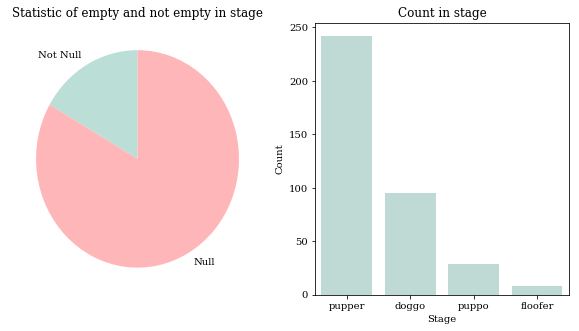

In [59]:
fig = plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
num_notna_stage = df_cleaned_twitter_archive_enhanced[df_cleaned_twitter_archive_enhanced["stage"].notna()]["stage"].count()
num_na_stage = df_cleaned_twitter_archive_enhanced.shape[0] - num_notna_stage
plt.pie([num_notna_stage, num_na_stage], startangle=90, labels=["Not Null", "Null"], colors=[color_board[0], color_board[1]])
plt.title(u"Statistic of empty and not empty in stage")

plt.subplot(1,2,2)
sns.countplot(data = df_cleaned_twitter_archive_enhanced, x = "stage",\
              color = color_board[0], order = ["pupper", "doggo", "puppo", "floofer"])
plt.title("Count in stage")
plt.xlabel("Stage")
plt.ylabel("Count");

(0, 1.5)

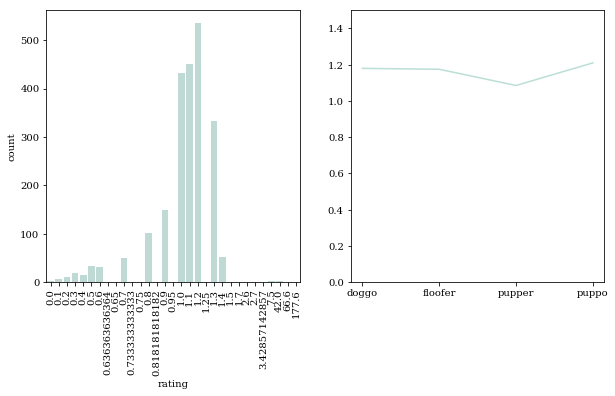

In [167]:
fig = plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
ax = sns.countplot(data= df_cleaned_twitter_archive_enhanced, x = "rating", color=color_board[0])
plt.xticks(rotation = 90);

plt.subplot(1,2,2)
df_stage_rating = df_cleaned_twitter_archive_enhanced.groupby("stage")["rating", "stage"].mean()
plt.plot(df_stage_rating, color = color_board[0])
plt.ylim((0, 1.5));

- 大部分狗没有进行明确的分级，只有少部分有分级
- pupper级别最多，doggo级别次之。
- 狗狗的评分大多数位于1.0到1.4之间，1.2的评分最多，其次是1.1和1.0
- 不同级别的狗狗的评分相差不大